In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            print(i)
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
            # print(F"{row['head']}: {row['age']:.4f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e6: age_factor = .5
else: age_factor = 1.05

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.random() for _ in cards_to_age.index]

cards_to_age.drop_duplicates(subset=['hash'], keep='first')
cards_to_age.sort_values('age').to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats

,age_sum,age_mean,head_count
head,,,
Jane Eyre,182.988215,18.298821,10
Azure VDI Project,192.381761,48.095440,4
General,205.017782,51.254446,4
Developer Mode,209.339810,52.334952,4
Azure Storage,232.725428,58.181357,4
Workera.ai,241.442481,48.288496,5
Dataverse Plugins,266.790603,38.112943,7
Dataverse,267.672381,53.534476,5
Diffusers Documentation,269.335467,53.867093,5


<Axes: >

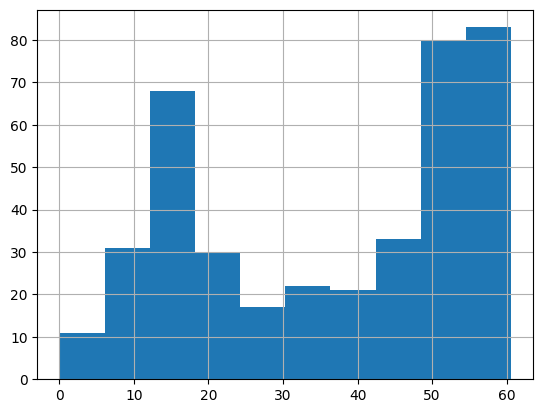

In [4]:
existing_cards['age'].hist()

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)

# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Shuffle

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

In [7]:
existing_cards[['head', 'age']].head(n = 10)

,head,age
0,Python,60.011252
1,PP365,60.539783
2,Power BI,59.700601
3,Azure Storage,60.001867
4,DNS,60.176389
5,sklearn,59.785661
6,sklearn,59.477299
7,Python,59.567399
8,DNS,59.184977
9,Diffusers Documentation,59.687140


# Headers with fewest notes first

In [8]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['oldest'] *= -1

# existing_cards.sort_values(['frequency', 'oldest', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

In [9]:
existing_cards['head'].value_counts()

Home Network Project              44
DNS                               36
Azure Kubernetes Learning Path    34
Search Engine Optimization        25
Python                            25
Diffusers Library                 21
sklearn                           20
Azure Functions                   19
PP365                             19
OData                             17
MS Identity Platform              11
Power BI                          11
Kali Linux                        10
Jane Eyre                         10
Diffusers from Hugging Face       10
AKS                                8
Dataverse Queries                  7
Conditional Access                 7
Dataverse Plugins                  7
Git                                6
pandas                             6
Azure OpenAI                       6
Azure AI Search                    6
Diffusers Documentation            5
Workera.ai                         5
Dataverse                          5
Azure VDI Project                  4
G

# Focus on one header

In [10]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# one_header = 'Diffusers Library'
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [11]:
existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('sum')
existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
remake_card_document(existing_cards)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [12]:
existing_cards

,head,body,hash,age,oldest
0,Python,The re.sub function replaces all occurrences o...,ad8039b7c4a3b134b904fb032b839cfe,60.011252,1330.832931
7,Python,".headers returns a dictionary-like object, all...",08f608eb929c3c7e3e0c3489472e902b,59.567399,1330.832931
17,Python,"In Python’s unittest package, you can use fixt...",44f1653fa2ef87ec33a19dd17f5feecc,59.393442,1330.832931
32,Python,Note: Requests uses a package called certifi t...,4fe35abbe0f88cf245115af67c03516c,58.385881,1330.832931
23,Python,"When a request fails, you may want your applic...",39d377ec4e301180b2e8174f65091692,57.912173,1330.832931
...,...,...,...,...,...
281,Jane Eyre,"Dun and Sere\n""Dun"" refers to a dull grayish-b...",be5c0cff4437b500f26ebd47a6e69448,18.637652,182.988215
290,Jane Eyre,Merino (muh-REE-noh)\nA breed of sheep prized ...,b6906fe6614468e4f390cf8c303d8c85,17.010880,182.988215
301,Jane Eyre,Physiognomy (fiz-ee-OG-nuh-mee)\nThe study or ...,696fc19d400e309efda67ed109a5132f,16.259470,182.988215
307,Jane Eyre,"Efface\nTo erase or remove something, especial...",bcfb2c30b676d2883b848af4fbfb46da,16.040979,182.988215


In [13]:
15.6e3/641*30/100

7.301092043681747